<a href="https://colab.research.google.com/github/SammyGbabs/Samuel_Babalola_RL_Summative/blob/main/Samuel_Babalola_RL_Summative_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
from gym import spaces

class IndoorNavEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(IndoorNavEnv, self).__init__()
        self.grid_size = 20  # Increased to 20x20 grid
        self.action_space = spaces.Discrete(5)  # Up, Down, Left, Right, Wait
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(16,), dtype=np.float32  # Added more features
        )

        # Enhanced house layout configuration
        self.rooms = {
            'living_room': (0,0,8,8),
            'kitchen': (0,12,8,20),
            'bedroom': (12,12,20,20),
            'bathroom': (12,0,20,8),
            'hallway': (8,8,12,12)
        }

        # Categorized obstacles
        self.obstacles = {
            'furniture': [(3,3), (5,15), (17,4), (9,9)],
            'appliances': [(2,18), (18,17)],
            'decorations': [(4,5), (15,15)],
            'floor_items': [(10,10), (14,14)]
        }

        # Doorway positions connecting rooms
        self.doorways = [(8,4), (4,8), (8,16), (12,16), (16,8)]

        # Initialize state variables
        self.current_room = None
        self.target_room = None
        self.agent_pos = None
        self.max_steps = 150  # Increased for larger environment
        self.current_step = 0

    def reset(self):
        self.agent_pos = (1,1)  # Start in living room
        self.current_room = 'living_room'
        self.target_room = np.random.choice(['kitchen', 'bedroom', 'bathroom'])
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        x, y = self.agent_pos

        # Proximity Sensors (5): Obstacle/door detection (front/back/left/right/current)
        proximity_sensors = [
            self._is_obstacle(x+1, y),  # Front
            self._is_obstacle(x-1, y),  # Back
            self._is_obstacle(x, y-1),  # Left
            self._is_obstacle(x, y+1),  # Right
            self._is_doorway(x, y),     # Current position (doorway)
        ]

        # Target Info (4): One-hot encoded target room
        target_info = self._target_room_info()  # One-hot encoded vector for target room

        # Navigation State (7): Normalized position, target distance, and remaining time
        navigation_state = [
            x / self.grid_size,          # Normalized x position
            y / self.grid_size,          # Normalized y position
            self._distance_to_target(),  # Distance to target room
            self.current_step / self.max_steps,  # Normalized time step
            0.0,  # Placeholder for additional sensor data, such as velocity or orientation
            0.0,  # Another placeholder for future sensors
            0.0,  # Placeholder for additional data
        ]

        # Combine all parts into one observation vector
        return np.concatenate([np.array(proximity_sensors), target_info, navigation_state], dtype=np.float32)

    def _target_room_info(self):
        # One-hot encoding for the target room
        target_rooms = ['kitchen', 'bedroom', 'bathroom', 'hallway']
        return np.array([1 if room == self.target_room else 0 for room in target_rooms], dtype=np.float32)

    def _is_obstacle(self, x, y):
        for category in self.obstacles.values():
            if (x,y) in category:
                return 1.0
        return 0.0

    def _is_doorway(self, x, y):
        return 1.0 if (x,y) in self.doorways else 0.0

    def _distance_to_target(self):
        tx1, ty1, tx2, ty2 = self.rooms[self.target_room]
        target_center = ((tx1+tx2)/2, (ty1+ty2)/2)
        return np.linalg.norm(np.array(self.agent_pos) - np.array(target_center)) / self.grid_size

    def _room_identification(self):
        return np.array([
            int(self.target_room == 'kitchen'),
            int(self.target_room == 'bedroom'),
            int(self.target_room == 'bathroom'),
            int(self.target_room == 'hallway')
        ], dtype=np.float32)

    def _in_target_room(self):
        x, y = self.agent_pos
        x1, y1, x2, y2 = self.rooms[self.target_room]
        return x1 <= x <= x2 and y1 <= y <= y2

    def step(self, action):
        self.current_step += 1

        # Movement handling
        if action < 4:
            dx, dy = [(1,0), (-1,0), (0,-1), (0,1)][action]
            new_x = np.clip(self.agent_pos[0]+dx, 0,19)
            new_y = np.clip(self.agent_pos[1]+dy, 0,19)

            if not self._is_obstacle(new_x, new_y):
                self.agent_pos = (new_x, new_y)

        # Reward calculation
        reward = -0.1  # Base time penalty
        done = False
        collision = False

        # Collision detection
        if self._is_obstacle(*self.agent_pos):
            reward = -5
            collision = True
            done = True

        # Target reached
        elif self._in_target_room():
            time_bonus = (self.max_steps - self.current_step) * 0.2
            reward = 15 + time_bonus
            done = True

        # Step limit termination
        elif self.current_step >= self.max_steps:
            reward -= 3
            done = True

        # Doorway bonus
        if not done and self._is_doorway(*self.agent_pos):
            reward += 1.0  # Increased doorway incentive

        return self._get_obs(), reward, done, {
            'collision': collision,
            'timeout': self.current_step >= self.max_steps,
            'current_room': self.current_room
        }

    def get_obstacle_types(self):
        """Return obstacle category at given position"""
        x, y = self.agent_pos
        for cat, positions in self.obstacles.items():
            if (x,y) in positions:
                return cat
        return None

In [6]:
!pip install stable-baselines3
!pip install shimmy>=2.0

In [26]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CallbackList
# from Environment.custom_env import IndoorNavEnv  # Your custom environment

# Define a custom callback class for reward logging
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.rewards_per_episode = []
        self.steps_per_episode = []
        self.episode_rewards = []  # Add this line to store episode rewards
        self.episode_steps = []  # Add this line to store episode steps

    def _on_step(self) -> bool:
        self.episode_rewards.append(self.locals["rewards"][0])  # Store reward for the step
        self.episode_steps.append(1)  # Store 1 step for each step

        if self.locals.get("done", False):  # Check if episode is done
            self.rewards_per_episode.append(np.sum(self.episode_rewards))  # Store total episode reward
            self.steps_per_episode.append(np.sum(self.episode_steps))  # Store total episode steps
            self.episode_rewards = []  # Reset episode rewards for next episode
            self.episode_steps = []  # Reset episode steps for next episode
        return True

# Create an instance of the custom callback
reward_callback = RewardCallback()

# Configuration
SEED = 42
LOG_DIR = "./dqn_logs/"
MODEL_DIR = "./dqn_models/"
TENSORBOARD_LOG = "./dqn_tensorboard/"

# Create environment
env = DummyVecEnv([lambda: IndoorNavEnv()])

# Test environment reset observation shape
obs = env.reset()
print("Initial Observation Shape:", obs.shape)

# Hyperparameters
params = {
    'learning_rate': 0.0003,
    'buffer_size': 100000,
    'batch_size': 256,
    'gamma': 0.995,
    'target_update_interval': 1000,
    'train_freq': 4,
    'gradient_steps': 1,
    'exploration_fraction': 0.15,
    'exploration_initial_eps': 1.0,
    'exploration_final_eps': 0.02,
    'policy_kwargs': {'net_arch': [512, 256]}
}

# Initialize model
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log=TENSORBOARD_LOG,
    **params
)

# Callbacks
stop_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=10, min_evals=5)
eval_callback = EvalCallback(
    env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=10000,
    callback_after_eval=stop_callback # Make sure stop_callback is passed here
)

# Training
# Wrap reward_callback in a CallbackList
# Remove stop_callback from the CallbackList; it's already linked to eval_callback
callback_list = CallbackList([eval_callback, reward_callback])

total_timesteps = 200000
model.learn(
    total_timesteps=total_timesteps,
    callback=callback_list, # Pass the CallbackList to model.learn
    tb_log_name="dqn_run",
    reset_num_timesteps=True
)

# Save final model
model.save(os.path.join(MODEL_DIR, "dqn_final_model"))

# Test trained model
def test_model(model_path, num_episodes=10):
    model = DQN.load(model_path)
    env = IndoorNavEnv()

    success, collision, total_rewards, total_steps = 0, 0, [], []

    for ep in range(num_episodes):
        obs = env.reset()
        done = False
        steps, episode_reward = 0, 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                if info['collision']:
                    collision += 1
                elif info.get('timeout', False):
                    pass
                else:
                    success += 1
                total_steps.append(steps)
                total_rewards.append(episode_reward)

    print(f"Success Rate: {success/num_episodes:.2f}")
    print(f"Collision Rate: {collision/num_episodes:.2f}")
    print(f"Avg Steps: {sum(total_steps)/len(total_steps):.2f}")
    print(f"Avg Reward: {sum(total_rewards)/len(total_rewards):.2f}")
    return total_rewards, total_steps

# Evaluate best model
test_rewards, test_steps = test_model(os.path.join(MODEL_DIR, "best_model"))

Streaming output truncated to the last 5000 lines.
|    total_timesteps  | 44931    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.864    |
|    n_updates        | 11207    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 576      |
|    fps              | 852      |
|    time_elapsed     | 53       |
|    total_timesteps  | 45531    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.63     |
|    n_updates        | 11357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 851      |
|    time_elapsed     | 54       |
|    total_timesteps  | 46131    |
| tr

In [30]:
print("Rewards:", reward_callback.rewards_per_episode)
print("Steps:", reward_callback.steps_per_episode)

Rewards: [np.float32(-18.100002), np.float32(-35.000004), np.float32(-30.000002), np.float32(-32.0), np.float32(20.799997), np.float32(-18.000002), np.float32(-0.1), np.float32(-17.900002), np.float32(-18.000002), np.float32(-0.1), np.float32(-17.900002), np.float32(-12.000001), np.float32(-0.1), np.float32(-17.900002), np.float32(-18.000002), np.float32(-0.1), np.float32(-10.900002), np.float32(58.200005), np.float32(-0.1), np.float32(-11.900002), np.float32(29.2), np.float32(-29.000002), np.float32(-31.000002), np.float32(-28.000004), np.float32(-35.000004), np.float32(-32.0), np.float32(20.699999), np.float32(-33.000004), np.float32(28.399998), np.float32(-29.000004), np.float32(32.9), np.float32(-33.000004), np.float32(-25.000004), np.float32(-31.000004), np.float32(26.2), np.float32(-0.1), np.float32(17.599998), np.float32(-0.1), np.float32(40.1), np.float32(-6.000001), np.float32(-0.1), np.float32(36.6), np.float32(-0.1), np.float32(-16.900002), np.float32(34.8), np.float32(23.8)

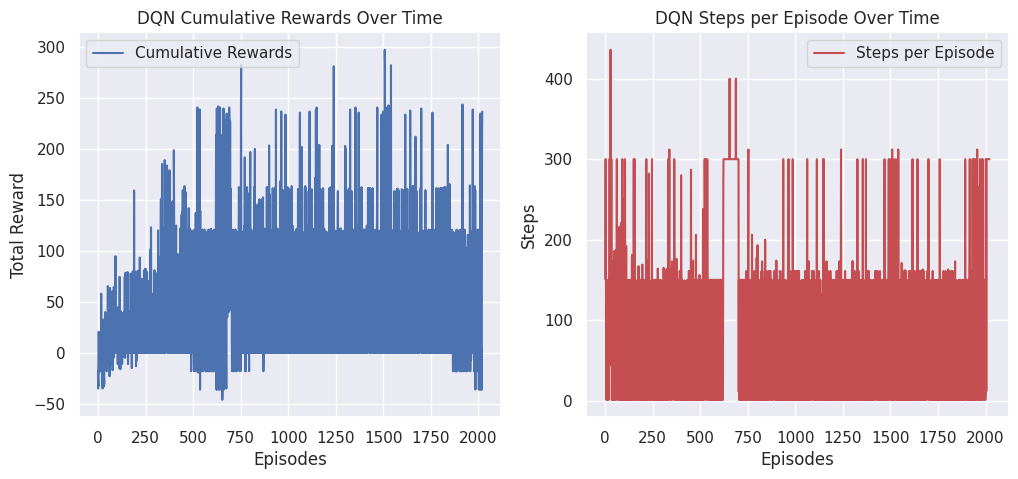

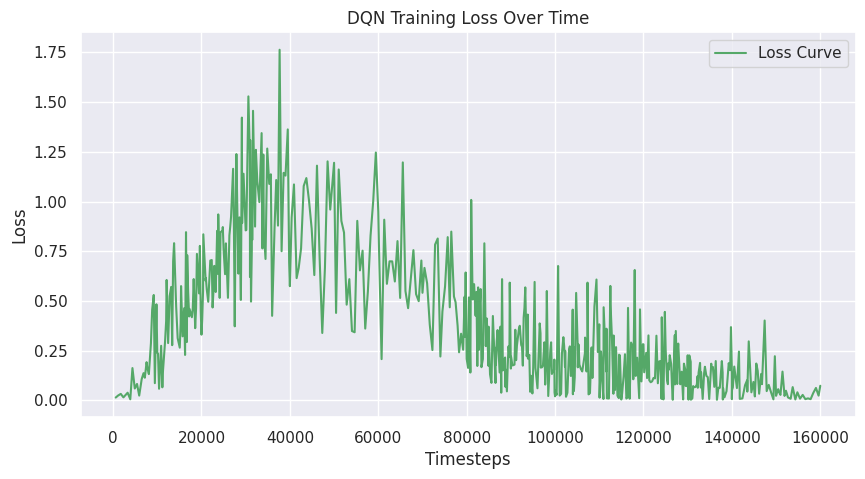

In [31]:
# Plot results
sns.set(style="darkgrid")

def plot_results(reward_callback):  # Pass reward_callback as an argument
    plt.figure(figsize=(12, 5))

    # Plot rewards
    plt.subplot(1, 2, 1)
    plt.plot(reward_callback.rewards_per_episode, label="Cumulative Rewards")  # Access from reward_callback
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("DQN Cumulative Rewards Over Time")
    plt.legend()

    # Plot steps
    plt.subplot(1, 2, 2)
    plt.plot(reward_callback.steps_per_episode, label="Steps per Episode", color='r')  # Access from reward_callback
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.title("DQN Steps per Episode Over Time")
    plt.legend()

    plt.show()

# Call plot_results with the reward_callback instance
plot_results(reward_callback)

# Plot loss curves from TensorBoard
def plot_loss_curve(log_dir=TENSORBOARD_LOG):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    # Update this part to search for event files recursively
    event_files = []
    for root, _, files in os.walk(log_dir):  # Walk through subdirectories
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))

    if not event_files:
        print("No TensorBoard event files found in the specified directory.")
        return

    # Choose the latest event file (you might need to adjust this logic)
    latest_event_file = max(event_files, key=os.path.getmtime)

    event_acc = EventAccumulator(latest_event_file)  # Use the latest file
    event_acc.Reload()
    losses = event_acc.Scalars("train/loss")  # Check if "loss" is the correct tag

    steps = [x.step for x in losses]
    values = [x.value for x in losses]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label="Loss Curve", color='g')
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("DQN Training Loss Over Time")
    plt.legend()
    plt.show()

plot_loss_curve()